In [5]:
# !pip install linearmodels

In [14]:
from pathlib import Path
from linearmodels.panel import PanelOLS

import requests
import numpy as np
import re
import pandas as pd
import statsmodels.api as sm
import csv
import matplotlib.pyplot as plt

In [15]:
transactions_df = pd.read_csv("main_features.csv", encoding="utf-8", low_memory=False)

In [16]:
# Keep relevant columns (Txn price, Area, Age, Type, mesh250m, Time fixed effect)
transactions_df = transactions_df[[
    "TradePrice",      # Transaction price
    "LogPrice",        # log of price per m² (dependent variable)
    "AreaSqM",         # Property size
    "Type",            # Property type
    "Mesh250m",        # Fine spatial grid identifier
    "BuildingYear",    # To compute property age
    "PeriodKey"        # Quarterly time fixed effect (e.g., "2005-Q3")
]].copy()

# Handle missing values
transactions_df["BuildingYear"] = (
    transactions_df["BuildingYear"]
    .astype(str)
    .str.extract(r"(\d{4})")[0]
    .astype(float)
)

transactions_df["age_unknown"] = transactions_df["BuildingYear"].isna().astype(int)
transactions_df["Age"] = 2025 - transactions_df["BuildingYear"]
transactions_df["Age"].fillna(transactions_df["Age"].median(), inplace=True)

# Feature engineering
transactions_df["log_area"] = np.log(transactions_df["AreaSqM"])

# Encode categorical IDs
transactions_df["mesh_id"]   = transactions_df["Mesh250m"].astype("category").cat.codes
transactions_df["period_id"] = transactions_df["PeriodKey"].astype("category").cat.codes

# Save mapping
mesh_map = dict(enumerate(transactions_df["Mesh250m"].astype("category").cat.categories))
period_map = dict(enumerate(transactions_df["PeriodKey"].astype("category").cat.categories))

# Set MultiIndex for PanelOLS
transactions_df = transactions_df.set_index(["mesh_id", "period_id"])
y = transactions_df["LogPrice"]
X = sm.add_constant(transactions_df[["log_area", "Age", "age_unknown"]])

# Fit model
mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
res = mod.fit(cov_type="robust")

print(res.summary)


/tmp/ipython-input-3513255624.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transactions_df["Age"].fillna(transactions_df["Age"].median(), inplace=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:               LogPrice   R-squared:                        0.7107
Estimator:                   PanelOLS   R-squared (Between):             -1.3027
No. Observations:              485093   R-squared (Within):               0.6948
Date:                Sun, Nov 09 2025   R-squared (Overall):              0.2930
Time:                        16:41:21   Log-likelihood                -3.291e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                   3.967e+05
Entities:                         582   P-value                           0.0000
Avg Obs:                       833.49   Distribution:                F(3,484430)
Min Obs:                       1.0000                                           
Max Obs:                       5651.0   F-statistic (robust):          1.496e+05
                            

In [18]:
# Safely attach fitted values & residuals
transactions_df = transactions_df.copy()

# Align on index
transactions_df["fitted"] = res.fitted_values.reindex(transactions_df.index)
transactions_df["resid"] = res.resids.reindex(transactions_df.index)

print(transactions_df[["fitted", "resid"]].head())

# Compute average fitted LogPrice per mesh × period
df_reset = transactions_df.reset_index()
avg_df = (
    df_reset.groupby(["mesh_id", "period_id"])["fitted"]
    .mean()
    .reset_index()
    .rename(columns={"fitted": "avg_logprice"})
)

#  Map encoded IDs back to original labels
mesh_categories = df_reset["Mesh250m"].astype("category").cat.categories
period_categories = df_reset["PeriodKey"].astype("category").cat.categories

avg_df["Mesh250m"] = avg_df["mesh_id"].map(dict(enumerate(mesh_categories)))
avg_df["PeriodKey"] = avg_df["period_id"].map(dict(enumerate(period_categories)))

# Convert log to price level and normalize
avg_df["PriceLevel"] = np.exp(avg_df["avg_logprice"])
avg_df["PriceIndex"] = (
    avg_df.groupby("Mesh250m")["PriceLevel"].transform(lambda x: x / x.iloc[0])
)

                      fitted     resid
mesh_id period_id                     
309     0          17.553974  0.993959
        0          17.658243  0.239102
        0          20.195986  1.738545
        0          17.917267  0.203222
213     0          16.338351 -0.212660


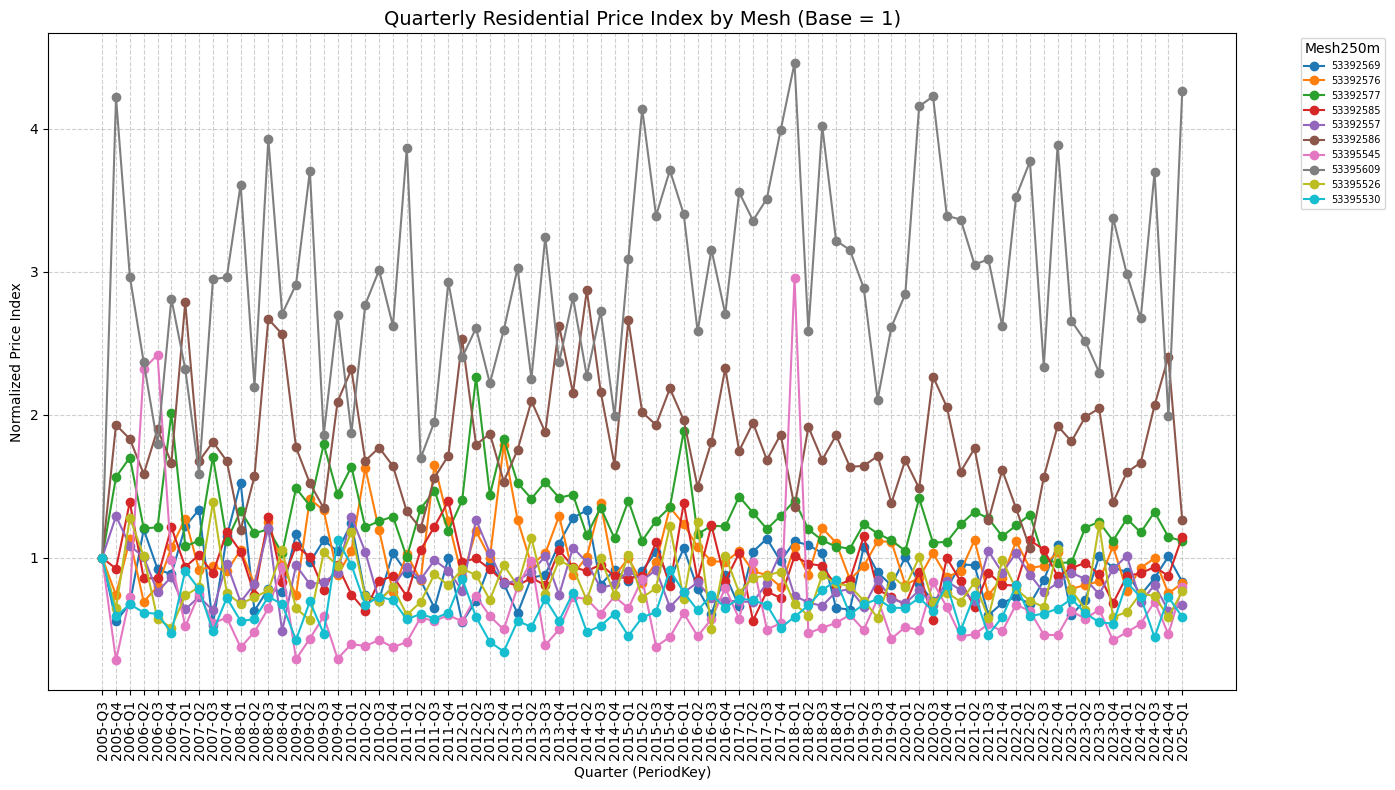

In [29]:
# Top 10 meshes with the highest number of observations in the dataset
plt.figure(figsize=(14, 8))
top_meshes = avg_df["Mesh250m"].value_counts().index[:10]

for mesh in top_meshes:
    subset = avg_df[avg_df["Mesh250m"] == mesh].sort_values("PeriodKey")
    plt.plot(subset["PeriodKey"], subset["PriceIndex"], marker="o", label=mesh)

plt.title("Quarterly Residential Price Index by Mesh (Base = 1)", fontsize=14)
plt.xlabel("Quarter (PeriodKey)")
plt.ylabel("Normalized Price Index")
plt.legend(title="Mesh250m", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=7)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [32]:
# Save the mesh-level quarterly price index

# Create a unique mapping of Mesh250m → Latitude, Longitude
transactions_df = pd.read_csv("main_features.csv", encoding="utf-8", low_memory=False)
mesh_coords = (
    transactions_df.reset_index()[["Mesh250m", "Latitude", "Longitude"]]
    .drop_duplicates(subset="Mesh250m")
)

mesh_price_index_df = avg_df[["Mesh250m", "PeriodKey", "PriceIndex"]].copy()
mesh_price_index_df = mesh_price_index_df.merge(mesh_coords, on="Mesh250m", how="left")

mesh_price_index_df.to_csv("mesh_quarterly_price_index.csv", index=False)

print(mesh_price_index_df.head())


   Mesh250m PeriodKey  PriceIndex   Latitude   Longitude
0  53392546   2005-Q3    1.000000  35.540512  139.707448
1  53392546   2005-Q4    0.249734  35.540512  139.707448
2  53392546   2006-Q3    0.136395  35.540512  139.707448
3  53392546   2007-Q1    0.348019  35.540512  139.707448
4  53392546   2007-Q3    0.166201  35.540512  139.707448
